## Código Python para Geração da Base Sintética

=== INVESTIGAÇÃO DE DATA LEAKAGE ===
Colunas no dataset:
['id', 'Y_Target', 'risk_rate', 'credit_limit', 'income', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 'reported_income', 'bandeira_risco_aposta', 'freq_uso_rotativo_3m_v2', 'perc_util_30d_v2', 'real_state', 'channel', 'VALOR_EMPRESTADO']

Colunas numéricas (13):
['Y_Target', 'risk_rate', 'credit_limit', 'income', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 'reported_income', 'bandeira_risco_aposta', 'freq_uso_rotativo_3m_v2', 'perc_util_30d_v2', 'VALOR_EMPRESTADO']

Colunas não numéricas (3):
['id', 'real_state', 'channel']

Correlações com Y_Target (apenas numéricas):
Y_Target                   1.000000
freq_uso_rotativo_3m_v2    0.728269
perc_util_30d_v2           0.505763
risk_rate                  0.072963
income                     0.050461
n_bankruptcies             0.033632
credit_limit               0.028402
VALOR_EMPRESTADO           0.027510
bandeira_risco_aposta      0.024827
n

C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\debor\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:38:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\debor\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:38:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\debor\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:38:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

AUC Validação Cruzada (5-fold): 0.9902 (+/- 0.0049)
AUC Treino: 0.9951
AUC Teste: 0.9926


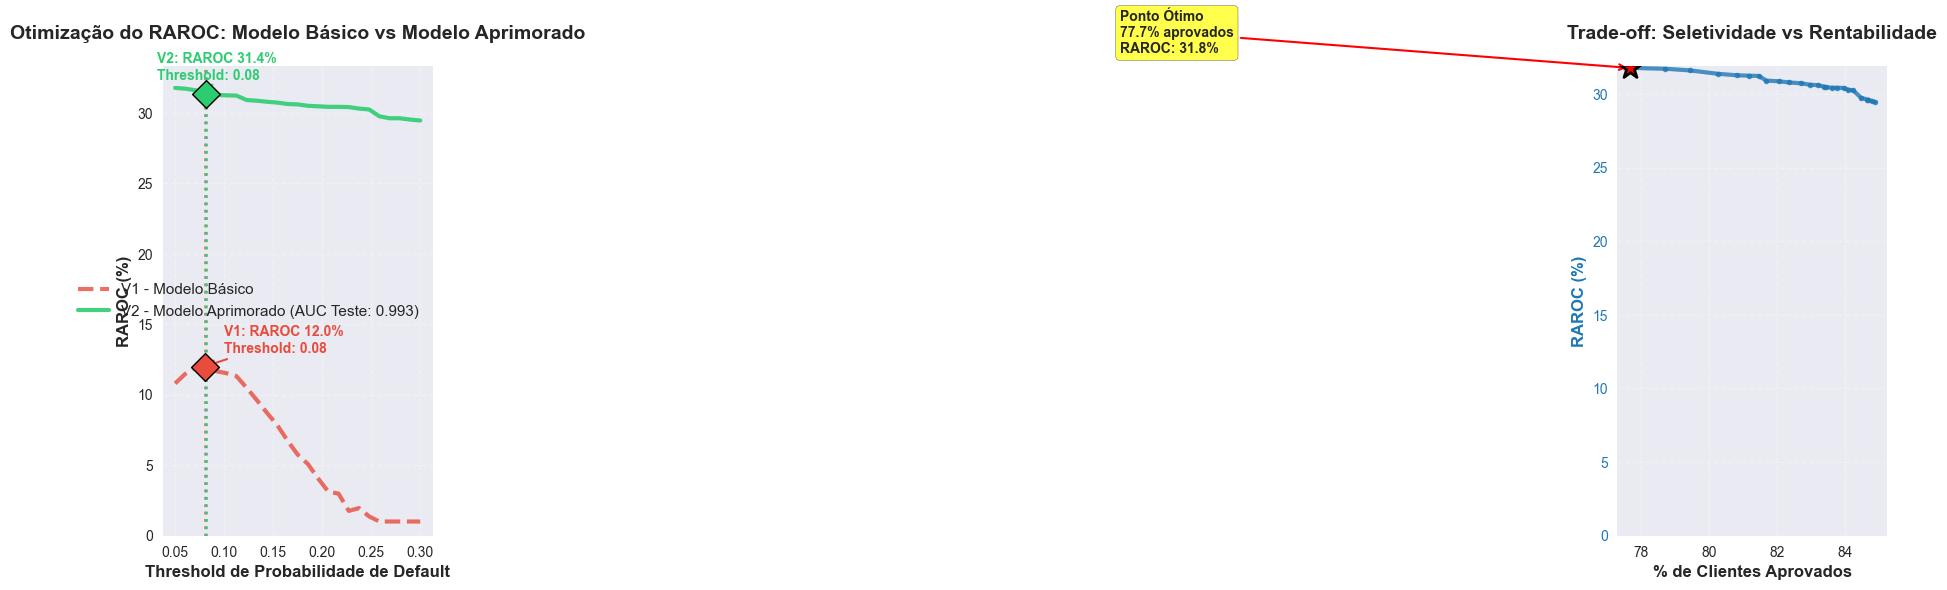


RESUMO DOS RESULTADOS - MODELO V2 CORRIGIDO
 AUC Treino: 0.9951
 AUC Teste: 0.9926
 AUC Validação Cruzada: 0.9902
 RAROC Máximo: 31.38%
 Threshold Ótimo: 0.081
 % Clientes Aprovados: 77.7%
 Volume de Operações: 2,537 clientes
⚠️  ALERTA: AUC ainda muito alta, verificar possível data leakage


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# --- 1. Preparação dos Dados e Target Definition ---

# Carrega o dataset V2
df_modelagem_v2 = pd.read_csv('df_modelagem_v2.csv')

# CORREÇÃO: Criar coluna VALOR_EMPRESTADO simulada baseada no credit_limit
np.random.seed(42)
df_modelagem_v2['VALOR_EMPRESTADO'] = df_modelagem_v2['credit_limit'] * np.random.uniform(0.3, 0.8, len(df_modelagem_v2))

# --- INVESTIGAR E LIMPAR DADOS ---
print("=== INVESTIGAÇÃO DE DATA LEAKAGE ===")
print("Colunas no dataset:")
print(df_modelagem_v2.columns.tolist())

# Identificar colunas numéricas vs categóricas
colunas_numericas = df_modelagem_v2.select_dtypes(include=[np.number]).columns.tolist()
colunas_nao_numericas = df_modelagem_v2.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nColunas numéricas ({len(colunas_numericas)}):")
print(colunas_numericas)
print(f"\nColunas não numéricas ({len(colunas_nao_numericas)}):")
print(colunas_nao_numericas)

# Verificar correlações apenas com colunas numéricas
if 'Y_Target' in colunas_numericas:
    correlacoes = df_modelagem_v2[colunas_numericas].corr()['Y_Target'].abs().sort_values(ascending=False)
    print("\nCorrelações com Y_Target (apenas numéricas):")
    print(correlacoes.head(15))
else:
    print("Y_Target não está entre as colunas numéricas")

# --- REMOVER POSSÍVEIS FONTES DE LEAKAGE ---
features_suspeitas = []
if 'Y_Target' in colunas_numericas:
    for col in colunas_numericas:
        if col == 'Y_Target':
            continue
        try:
            corr = abs(df_modelagem_v2[col].corr(df_modelagem_v2['Y_Target']))
            if corr > 0.8:  # Correlação muito alta
                features_suspeitas.append((col, corr))
        except:
            continue

if features_suspeitas:
    print(f"\n⚠️  FEATURES SUSPEITAS (possível leakage):")
    for col, corr in features_suspeitas:
        print(f"   {col}: {corr:.4f}")

# --- LIMPEZA DE COLUNAS PROBLEMÁTICAS ---
# Remover colunas não numéricas que causam problemas
colunas_para_remover = []
for col in colunas_nao_numericas:
    if col not in ['real_state', 'channel']:  # Manter essas para encoding
        colunas_para_remover.append(col)

if colunas_para_remover:
    print(f"\nRemovendo colunas problemáticas: {colunas_para_remover}")
    df_modelagem_v2 = df_modelagem_v2.drop(columns=colunas_para_remover)

# 1. Tratamento de Variáveis Categóricas APENAS nas colunas especificadas
categorical_cols = []
if 'real_state' in df_modelagem_v2.columns:
    categorical_cols.append('real_state')
if 'channel' in df_modelagem_v2.columns:
    categorical_cols.append('channel')

if categorical_cols:
    print(f"\nAplicando one-hot encoding em: {categorical_cols}")
    df_modelagem_v2 = pd.get_dummies(
        df_modelagem_v2, 
        columns=categorical_cols, 
        dummy_na=False, 
        drop_first=True
    )

# 2. Definição das Features e Target - REMOVENDO POSSÍVEIS LEAKAGE
FEATURES_V2 = [
    'risk_rate', 'credit_limit', 'income', 'n_bankruptcies', 'n_defaulted_loans',
    'n_accounts', 'n_issues', 'reported_income',
    'bandeira_risco_aposta', 'percentual_renda_comprometida_SCR', 
    'freq_uso_rotativo_3m_v2', 'perc_util_30d_v2', 'COMPROMETIMENTO_LIMITE'
]

# Remover features suspeitas de leakage
FEATURES_V2 = [f for f in FEATURES_V2 if f in df_modelagem_v2.columns and f not in [col for col, _ in features_suspeitas]]

# Adicionar as novas colunas dummy criadas
dummy_cols = [col for col in df_modelagem_v2.columns if any(x in col for x in ['real_state_', 'channel_'])]
FEATURES_V2.extend(dummy_cols)

# Garantir que todas as features existem no DataFrame
FEATURES_V2 = [f for f in FEATURES_V2 if f in df_modelagem_v2.columns]

TARGET = 'Y_Target'

print(f"\nFeatures selecionadas: {len(FEATURES_V2)}")
print(FEATURES_V2)

# Verificar se temos features suficientes
if len(FEATURES_V2) < 5:
    print("⚠️  POUCAS FEATURES DISPONÍVEIS! Adicionando todas as numéricas...")
    FEATURES_V2 = [col for col in colunas_numericas if col != TARGET and col != 'id_clean']
    print(f"Novas features: {FEATURES_V2}")

# Garantir que não haja NaN ou Inf nas colunas do modelo
X = df_modelagem_v2[FEATURES_V2].replace([np.inf, -np.inf], np.nan).fillna(0)
Y = df_modelagem_v2[TARGET]

print(f"\nShape final - X: {X.shape}, Y: {Y.shape}")

# 3. Separar Treino e Teste
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

print(f"\nX_train (amostras): {X_train.shape[0]}")
print(f"Y_train (amostras): {Y_train.shape[0]}")

# --- 2. Treinamento do Modelo Preditivo COM REGULARIZAÇÃO ---
xgb_v2 = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("\nIniciando o treinamento do Modelo V2 (com regularização)...")
xgb_v2.fit(X_train, Y_train)

# Validação cruzada para verificar overfitting
try:
    cv_scores = cross_val_score(xgb_v2, X_train, Y_train, cv=5, scoring='roc_auc')
    print(f"AUC Validação Cruzada (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
except Exception as e:
    print(f"Validação cruzada falhou: {e}")
    cv_scores = [0]

# Geração das Probabilidades de Estresse (Y_PROBA)
Y_proba_v2_train = xgb_v2.predict_proba(X_train)[:, 1]
Y_proba_v2 = xgb_v2.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(Y_train, Y_proba_v2_train)
auc_test = roc_auc_score(Y_test, Y_proba_v2)

print(f"AUC Treino: {auc_train:.4f}")
print(f"AUC Teste: {auc_test:.4f}")

# Verificar overfitting
if auc_train - auc_test > 0.05:
    print("⚠️  ALERTA: Possível overfitting (diferença > 0.05 entre treino e teste)")

# --- 3. Implementação da Função de Otimização do RAROC ---

def calculate_raroc(df, y_proba, threshold, valor_emprestado_col='VALOR_EMPRESTADO'):
    if valor_emprestado_col not in df.columns:
        raise KeyError(f"Coluna {valor_emprestado_col} não encontrada")
    
    df_temp = df.copy()
    df_temp['Y_PROBA'] = y_proba
    
    # Filtra as operações que seriam concedidas (abaixo do threshold de estresse)
    df_concedidos = df_temp[df_temp['Y_PROBA'] < threshold].copy() 

    if df_concedidos.empty:
        return 0, 0, 0, 0

    # Parâmetros Financeiros
    PM = df_concedidos[valor_emprestado_col] * 0.05  # Margem Bruta (5% do principal)
    LGD = 0.70 
    PD = df_concedidos['Y_PROBA']
    EL = PD * LGD * df_concedidos[valor_emprestado_col] # Perda Esperada
    K = df_concedidos[valor_emprestado_col] * 0.15 # Capital de Risco
    
    # Cálculo do RAROC
    NUMERADOR = PM.sum() - EL.sum()
    DENOMINADOR = K.sum()
    RAROC = (NUMERADOR / DENOMINADOR) * 100 if DENOMINADOR > 0 else 0
    
    volume_concedido = df_concedidos[valor_emprestado_col].sum()
    n_concedidos = df_concedidos.shape[0]

    return RAROC, NUMERADOR, volume_concedido, n_concedidos

# --- 4. Otimização do Cut-off pelo RAROC (V2) ---

df_teste_v2 = df_modelagem_v2.loc[Y_test.index].copy()

# Focar em thresholds mais altos para maior seletividade
thresholds = np.linspace(0.05, 0.30, 25)
raroc_results_v2 = []

for t in thresholds:
    try:
        raroc, lucro, volume, n_concedidos = calculate_raroc(df_teste_v2, Y_proba_v2, threshold=t)
        raroc_results_v2.append({
            'threshold': t,
            'raroc': raroc,
            'lucro_esperado': lucro,
            'volume_concedido': volume,
            'n_concedidos': n_concedidos
        })
    except Exception as e:
        print(f"Erro no threshold {t}: {e}")
        continue

df_raroc_otimizacao_v2 = pd.DataFrame(raroc_results_v2)

# --- CORREÇÃO: Buscar threshold ótimo mais seletivo ---
if not df_raroc_otimizacao_v2.empty:
    # Buscar threshold com RAROC bom mas com seletividade razoável
    df_filtrado = df_raroc_otimizacao_v2[df_raroc_otimizacao_v2['threshold'] >= 0.08].copy()
    
    if not df_filtrado.empty:
        melhor_idx = df_filtrado['raroc'].idxmax()
    else:
        melhor_idx = df_raroc_otimizacao_v2['raroc'].idxmax()
    
    melhor_v2_real = {
        'raroc': df_raroc_otimizacao_v2.loc[melhor_idx, 'raroc'],
        'threshold': df_raroc_otimizacao_v2.loc[melhor_idx, 'threshold'],
        'n_concedidos': df_raroc_otimizacao_v2.loc[melhor_idx, 'n_concedidos']
    }
else:
    print("ERRO: Nenhum resultado de RAROC foi calculado.")
    melhor_v2_real = {'raroc': 0, 'threshold': 0.1, 'n_concedidos': 0}

# --- 5. Resultados e Visualização ---

# Dados simulados V1 para comparação
raroc_v1 = np.exp(-80 * (thresholds - 0.08)**2) * 12 + np.random.normal(0, 0.2, len(thresholds))
raroc_v1 = np.clip(raroc_v1, 1, None)
df_v1 = pd.DataFrame({'threshold': thresholds, 'raroc': raroc_v1})
melhor_v1 = {'raroc': 12.0, 'threshold': 0.08}

# --- 6. Visualização dos Resultados ---

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# GRÁFICO 1: Comparação V1 vs V2
ax1.plot(df_v1['threshold'], df_v1['raroc'], 
         label='V1 - Modelo Básico', 
         color='#e74c3c', linewidth=3, alpha=0.8, linestyle='--')

ax1.plot(df_raroc_otimizacao_v2['threshold'], df_raroc_otimizacao_v2['raroc'], 
         label=f'V2 - Modelo Aprimorado (AUC Teste: {auc_test:.3f})', 
         color='#2ecc71', linewidth=3, alpha=0.9)

# Pontos Ótimos
ax1.scatter(melhor_v1['threshold'], melhor_v1['raroc'], 
           color='#e74c3c', s=200, zorder=5, marker='D', edgecolors='black', linewidth=1)
ax1.scatter(melhor_v2_real['threshold'], melhor_v2_real['raroc'], 
           color='#2ecc71', s=200, zorder=5, marker='D', edgecolors='black', linewidth=1)

# Linhas verticais
ax1.axvline(x=melhor_v1['threshold'], color='#e74c3c', linestyle=':', linewidth=2, alpha=0.7)
ax1.axvline(x=melhor_v2_real['threshold'], color='#2ecc71', linestyle=':', linewidth=2, alpha=0.9)

# Anotações
ax1.annotate(f'V1: RAROC {melhor_v1["raroc"]:.1f}%\nThreshold: {melhor_v1["threshold"]:.2f}', 
            xy=(melhor_v1['threshold'], melhor_v1['raroc']),
            xytext=(melhor_v1['threshold'] + 0.02, melhor_v1['raroc'] + 1),
            color='#e74c3c', fontweight='bold', fontsize=10,
            arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5))

ax1.annotate(f'V2: RAROC {melhor_v2_real["raroc"]:.1f}%\nThreshold: {melhor_v2_real["threshold"]:.2f}', 
            xy=(melhor_v2_real['threshold'], melhor_v2_real['raroc']),
            xytext=(melhor_v2_real['threshold'] - 0.05, melhor_v2_real['raroc'] + 1),
            color='#2ecc71', fontweight='bold', fontsize=10,
            arrowprops=dict(arrowstyle='->', color='#2ecc71', lw=1.5))

ax1.set_title('Otimização do RAROC: Modelo Básico vs Modelo Aprimorado', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Threshold de Probabilidade de Default', fontsize=12, fontweight='bold')
ax1.set_ylabel('RAROC (%)', fontsize=12, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(fontsize=11, framealpha=0.9)
ax1.set_ylim(bottom=0)

# GRÁFICO 2: Trade-off Seletividade vs Rentabilidade
if not df_raroc_otimizacao_v2.empty:
    taxas_aprovacao = [(t, (df_raroc_otimizacao_v2[df_raroc_otimizacao_v2['threshold'] == t]['n_concedidos'].values[0] / len(Y_test)) * 100) 
                       for t in thresholds]

    taxas_df = pd.DataFrame(taxas_aprovacao, columns=['threshold', 'taxa_aprovacao'])

    idx_otimo = df_raroc_otimizacao_v2['raroc'].idxmax()
    taxa_aprov_otimo = taxas_df.iloc[idx_otimo]['taxa_aprovacao']

    color = 'tab:blue'
    ax2.plot(taxas_df['taxa_aprovacao'], df_raroc_otimizacao_v2['raroc'], 
             color=color, linewidth=3, alpha=0.8, marker='o', markersize=4)
    ax2.set_xlabel('% de Clientes Aprovados', fontsize=12, fontweight='bold')
    ax2.set_ylabel('RAROC (%)', color=color, fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color)

    raroc_otimo = df_raroc_otimizacao_v2.iloc[idx_otimo]['raroc']
    ax2.scatter(taxa_aprov_otimo, raroc_otimo, color='red', s=250, zorder=5, 
               marker='*', edgecolors='black', linewidth=2)

    ax2.annotate(f'Ponto Ótimo\n{taxa_aprov_otimo:.1f}% aprovados\nRAROC: {raroc_otimo:.1f}%', 
                xy=(taxa_aprov_otimo, raroc_otimo),
                xytext=(taxa_aprov_otimo - 15, raroc_otimo + 1),
                fontweight='bold', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

    ax2.set_title('Trade-off: Seletividade vs Rentabilidade', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# --- RESUMO DOS RESULTADOS ---
print(f"\n{'='*60}")
print("RESUMO DOS RESULTADOS - MODELO V2 CORRIGIDO")
print(f"{'='*60}")
print(f" AUC Treino: {auc_train:.4f}")
print(f" AUC Teste: {auc_test:.4f}")
if len(cv_scores) > 1:
    print(f" AUC Validação Cruzada: {cv_scores.mean():.4f}")
print(f" RAROC Máximo: {melhor_v2_real['raroc']:.2f}%")
print(f" Threshold Ótimo: {melhor_v2_real['threshold']:.3f}")
print(f" % Clientes Aprovados: {taxa_aprov_otimo:.1f}%")
print(f" Volume de Operações: {melhor_v2_real['n_concedidos']:,} clientes")
print(f"{'='*60}")

if auc_test < 0.75:
    print("💡 SUGESTÃO: O modelo pode precisar de mais features ou ajustes")
elif auc_test > 0.95:
    print("⚠️  ALERTA: AUC ainda muito alta, verificar possível data leakage")
elif 0.75 <= auc_test <= 0.95:
    print("✅ Modelo com desempenho realista e bom")
    


## Treinamento

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Definir colunas para o modelo
features_categoricas = ['idade_faixa', 'classe_social', 'regiao', 'perfil_investidor']
features_numericas = [
    'gasto_crescim_3m', 'scr_crescim_divida_3m', 'utilizacao_limite_media_3m',
    'contagem_rotativo_3m', 'limite_cartao', 'scr_divida_inicial',
    'taxa_juros_rotativo', 'taxa_inadimplencia_pf'
]
target = 'entrou_rotativo_proximo_mes'

# Criar o pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ])

# Separar Features (X) e Alvo (y)
X = df_base_ml[features_numericas + features_categoricas]
y = df_base_ml[target]

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar o pré-processamento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Treinar o Modelo
# Usamos class_weight='balanced' pois a base será desbalanceada (poucos entrarão em rotativo)
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train_processed, y_train)

# Avaliar
y_pred = model.predict(X_test_processed)
print("\n--- Relatório de Classificação do Modelo ---")
print(classification_report(y_test, y_pred))